Here's the page I found for this data analysis tutorial : https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-learn-data-science-python-scratch-2/

You'll also find the dataset we use here : https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

In [89]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [90]:
# path contains \ and it seems like it generates a unicode error. Let's just
# replace backslashes by forward slashes

csv_file = "C:/Users/Lucho/Desktop/Code/DataAnalysis/Loan_Prediction_Problem/train_u6lujuX_CVtuZ9i.csv"

df = pd.read_csv(csv_file)

## Quick Data Exploration

In [91]:
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [92]:
df.describe() # get summary of numerical variables
# describe() function would provide count, mean,
# standard deviation (std), min, quartiles and max in its output

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


We can see from here there are some missing values.
- First LoanAmount has (614 - 592) 22 missing values.
- LoanAmount_Term has (614 - 600) 14 missing values.
- Credid_History has (614 - 564) 50 missing values.

Also we can deduce that we only 84% applicants have a credit history. Indeed, the mean of Credit_History is 0.84. Therefore, this column's value can only be 0 or 1 (1 if you have a credit history and 0 if you don't).

As it is said on the site, it's possible to have an idea of a possible skew in the data by comparing the **mean** to the **median** i.e. the 50% figure.

The dataset also contains non-numerical values (e.g. Property_Area, Gender, etc.). We can look at frequency distribution to understand wheter they make sense or not. Let's print the frequency table of Property_Area :

In [93]:
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

## Distribution analysis

Let's study distribution of various variables. In the first place, we'll deal with numeric variables such as ApplicantIncome and LoanAmount.
Let's start by plotting the histogram of ApplicantIncome :

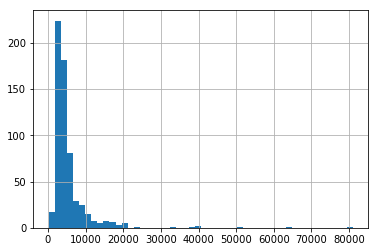

In [94]:
df['ApplicantIncome'].hist(bins=50)

We can see there are few extreme values.

Next, we look at box plots (boîte à moustaches in French) to understand the distributions.

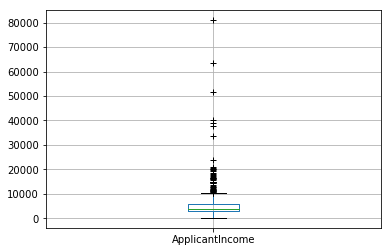

In [95]:
df.boxplot(column='ApplicantIncome', sym="+")

This confirms the presence of outlier (valeur aberrante) and extreme values. It can be explained by the income disparity in the society. Also we're looking at people from different backgrounds. So we're gonna segragate them by Education :

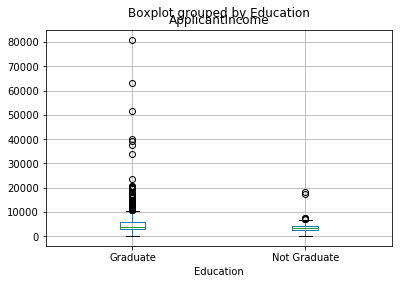

In [96]:
df.boxplot(column='ApplicantIncome', by = 'Education')

We can see means between income of graduates and non-graduates are really close. But people who graduate are more likely to have high and very high incomes.

Now let's look at the histogram and boxplot of LoanAmount :

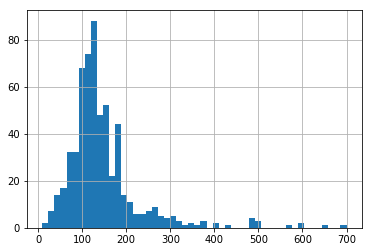

In [97]:
df['LoanAmount'].hist(bins=50)

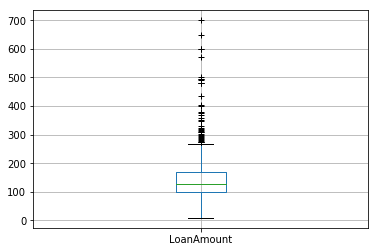

In [98]:
df.boxplot(column='LoanAmount', sym="+")

Also here, there are some extreme value. It will be necessary to do some **data munging** (nettoyage de données) for both ApplicantIncome and LoanAmount.
ApplicantIncome has a few extreme values while LoanAmount has both missing and extreme values, which demands more a deeper understanding.

## Categorical variable analysis

Now that we saw how ApplicantIncome and LoanIncome are distributed, it's time to  look into categorical variables. We will use Excel style pivot table and cross-tabulation. For instance, let us look at the odds of getting a loan based on credit history. This can be done in MS Excel using a pivot table as :

In [99]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print('Frequency Table for Credit History:')
print(temp1)

print('\nProbility of getting loan for each Credit History class:')
print(temp2)

Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class:
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


This prints a similar pivot table like the MS Excel one. We actually can plot this using matplotlib :

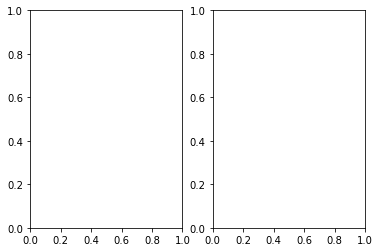

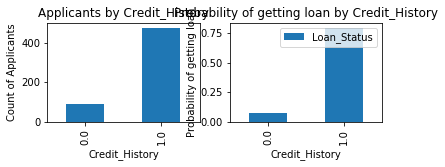

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set = plt.figure(figsize=(6,4))
#gs = gridspec.GridSpec(1, 2, gridspec_kw = {'width_ratios':[3, 1]})

ax1 = plt.subplot(2, 2, 1)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title('Applicants by Credit_History')
temp1.plot(ax=ax1, kind='bar')

ax2 = plt.subplot(2, 2, 2)
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title('Probability of getting loan by Credit_History')
temp2.plot(ax=ax2, kind='bar')